In [1]:
import transformers
from transformers import ViTFeatureExtractor, ViTForImageClassification, TrainingArguments, Trainer
from datasets import Dataset, load_metric
import torch
from torchvision import transforms
from IPython.display import Image as Img
from PIL import Image
import os
import random
import numpy as np

from image_dataset import ImageDataSet #, collate_fn

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [3]:
# define scraping labels based off of the possible classes
labels = [['dark', 'somber', 'gloomy', 'shadowy', 'dark art', 'dark landscape', 'gloomy art'], 
          ['whimsical', 'colorful art', 'fair world', 'happy fantasy world', 'bright picture', 'whimsical music', 'bright art', 'bright landscape'],
          ['electronic music', 'retro', 'synthwave', 'techno party', 'night club', 'techno wallpaper', 'disco'],
          ['calm', 'peaceful', 'placid', 'calm water', 'peaceful art', 'peaceful landscape', 'calm art', 'serene'],
          ['founding fathers', 'classical', 'old timey art', 'vintage', 'cathedral', 'old england dainty', 'classical art']]

data_dir = './data/'

image_data = ImageDataSet(data_dir, label_categories=labels)
labels, counts = image_data.print_label_dist()
labels, counts = labels, counts
print("Total numer of images in the dataset:", len(image_data))
print("\nLabel distribution:")
for i in range(len(labels)):
    print(str(labels[i]) + ':', counts[i])

['.png', '.jpg', '.jpeg']
Making data directory...
Scraping images...
===> Extracting 'dark' images...
===> Extracting 'somber' images...
===> Extracting 'gloomy' images...
===> Extracting 'shadowy' images...
===> Extracting 'dark art' images...
===> Extracting 'dark landscape' images...
===> Extracting 'gloomy art' images...
===> Extracting 'whimsical' images...
===> Extracting 'colorful art' images...
===> Extracting 'fair world' images...
===> Extracting 'happy fantasy world' images...
===> Extracting 'bright picture' images...
===> Extracting 'whimsical music' images...
===> Extracting 'bright art' images...
===> Extracting 'bright landscape' images...
===> Extracting 'electronic music' images...
===> Extracting 'retro' images...
===> Extracting 'synthwave' images...
===> Extracting 'techno party' images...
===> Extracting 'night club' images...
===> Extracting 'techno wallpaper' images...
===> Extracting 'disco' images...
===> Extracting 'calm' images...
===> Extracting 'peaceful'

Class label: 0 Size: 474 296


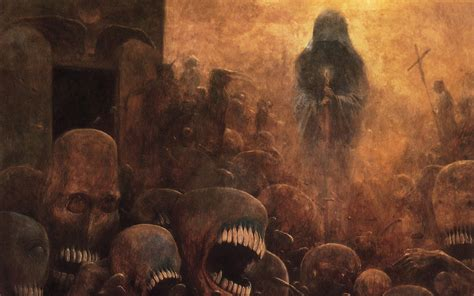

Class label: 1 Size: 474 296


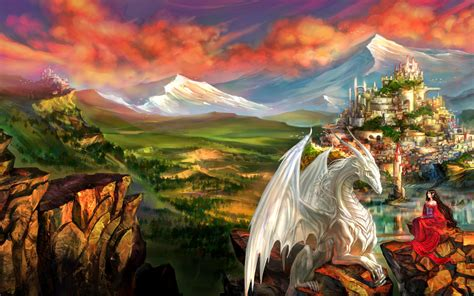

Class label: 2 Size: 474 315


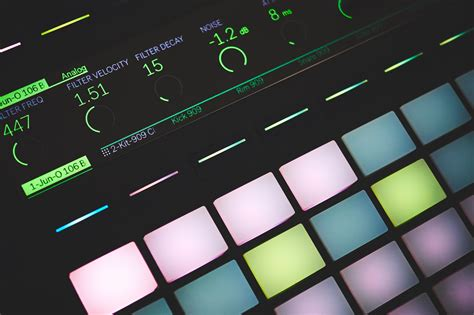

Class label: 3 Size: 474 266


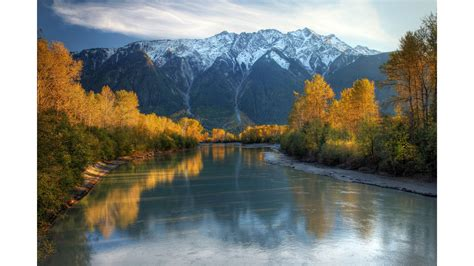

Class label: 4 Size: 474 521


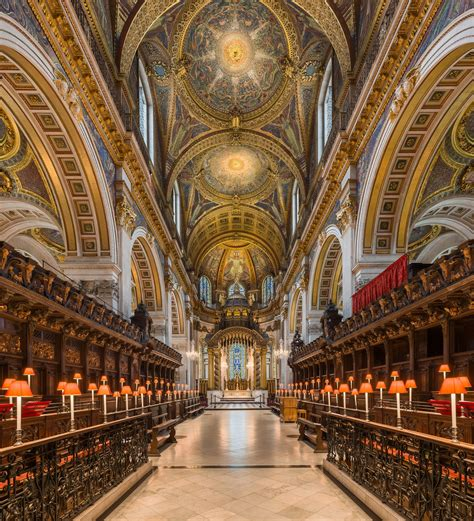

In [4]:
# visualize the data
for folder in sorted(os.listdir(data_dir)):
    rand_file = random.choice(os.listdir(data_dir + folder + '/'))
    ext = os.path.splitext(rand_file)[1]
    im_file = data_dir + folder + '/' + rand_file
    im = Image.open(im_file)
    width, height = im.size
    
    print("Class label:", folder, "Size:", width,height)
    display(Img(filename=im_file))

In [5]:
model_name = 'google/vit-base-patch16-224-in21k'
feature_extractor = ViTFeatureExtractor.from_pretrained(model_name)
labels = ['dark/somber', 'happy/bright', 'techno/disco', 'calm/peaceful', 'classical']
model = ViTForImageClassification.from_pretrained(model_name,
                                                  num_labels=len(labels),
                                                  id2label={str(i): c for i, c in enumerate(labels)},
                                                  label2id={c: str(i) for i, c in enumerate(labels)}).to(device)

/opt/conda/lib/python3.7/site-packages/transformers/models/vit/feature_extraction_vit.py:31: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  FutureWarning,
Some weights of the model checkpoint at google/vit-base-patch16-224-in21k were not used when initializing ViTForImageClassification: ['pooler.dense.bias', 'pooler.dense.weight']
- This IS expected if you are initializing ViTForImageClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ViTForImageClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ViTForImageClassification were not initialized from the model ch

In [6]:
# define function to prepare dataset for huggingface implementation
def transform(batch):
    inputs = feature_extractor([x for x in batch['image']], return_tensors='pt')
    inputs['labels'] = batch['label']
    return inputs

In [7]:
# define fine-tuning hyper parameters
epochs = 15
batch_size = 16
output_dir = './vit'
lr = 2e-4
train_split = 0.85

In [8]:
# train test split the data
train_size = int(train_split * len(image_data))
test_size = len(image_data) - train_size
    
train_data, eval_data = torch.utils.data.random_split(image_data, [train_size, test_size])

In [9]:
# convert from pytorch dataset to huggingface
def gen_train():
    for idx in range(len(train_data)):
        img, label = train_data[idx]
        yield {'image':img, 'label':label}
        
def gen_eval():
    for idx in range(len(eval_data)):
        img, label = eval_data[idx]
        yield {'image':img, 'label':label}

In [10]:
train_ds =  Dataset.from_generator(gen_train)
eval_ds = Dataset.from_generator(gen_eval)

prepared_train = train_ds.with_transform(transform)
prepared_eval = eval_ds.with_transform(transform)

Generating train split: 0 examples [00:00, ? examples/s]

Dataset generator downloaded and prepared to /home/ref2156/.cache/huggingface/datasets/generator/default-ec393253bf53b1fe/0.0.0. Subsequent calls will reuse this data.


Generating train split: 0 examples [00:00, ? examples/s]

Dataset generator downloaded and prepared to /home/ref2156/.cache/huggingface/datasets/generator/default-8826253741595158/0.0.0. Subsequent calls will reuse this data.


In [11]:
# define a function to compute the metrics during train/eval
metric = load_metric("accuracy")
def compute_metrics(p):
    return metric.compute(predictions=np.argmax(p.predictions, axis=1), references=p.label_ids)

def collate_fn(batch):
    return {'pixel_values': torch.stack([x['pixel_values'] for x in batch]),
            'labels': torch.tensor([x['labels'] for x in batch])}

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  


In [12]:
training_args = TrainingArguments(output_dir=output_dir,
                                  per_device_train_batch_size=batch_size,
                                  evaluation_strategy="epoch",
                                  save_strategy="epoch",
                                  num_train_epochs=epochs,
                                  fp16=True,
                                  save_steps=100,
                                  eval_steps=100,
                                  logging_steps=10,
                                  learning_rate=lr,
                                  save_total_limit=2,
                                  remove_unused_columns=False,
                                  push_to_hub=False,
                                  # report_to='tensorboard',
                                  load_best_model_at_end=True)

trainer = Trainer(model=model,
                  args=training_args,
                  data_collator=collate_fn,
                  compute_metrics=compute_metrics,
                  train_dataset=prepared_train,
                  eval_dataset=prepared_eval,
                  tokenizer=feature_extractor)

In [13]:
# train the ViT
train_results = trainer.train()
trainer.save_model()
trainer.log_metrics("train", train_results.metrics)
trainer.save_metrics("train", train_results.metrics)
trainer.save_state()

/opt/conda/lib/python3.7/site-packages/transformers/optimization.py:395: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


Epoch,Training Loss,Validation Loss,Accuracy
1,0.486800,0.558470,0.812155
2,0.322500,0.332082,0.895028
3,0.135100,0.421304,0.883978
4,0.139500,0.351061,0.906077
5,0.014700,0.471979,0.878453
6,0.047500,0.433321,0.883978
7,0.007300,0.467564,0.883978
8,0.005700,0.475679,0.889503
9,0.005000,0.485552,0.889503
10,0.004400,0.493893,0.889503


***** train metrics *****
  epoch                    =         15.0
  total_flos               = 1105313870GF
  train_loss               =       0.0923
  train_runtime            =   0:06:55.77
  train_samples_per_second =       36.834
  train_steps_per_second   =        2.309


In [15]:
# evaluate the fine-tuning
metrics = trainer.evaluate(prepared_eval)
trainer.log_metrics("eval", metrics)
trainer.save_metrics("eval", metrics)

***** eval metrics *****
  epoch                   =       15.0
  eval_accuracy           =      0.895
  eval_loss               =     0.3321
  eval_runtime            = 0:00:02.65
  eval_samples_per_second =      68.26
  eval_steps_per_second   =      8.674
